## Downloading the data from kaggle

In [ ]:
!pip install kaggle
from google.colab import files
from datetime import datetime
api_token = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [ ]:
!kaggle datasets download -d shadabhussain/flickr8k

100% 2.13G/2.13G [00:24<00:00, 43.5MB/s]



In [ ]:
import os
from IPython.display import Image, display
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM,TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [ ]:
os.listdir('./Flickr_Data/Flickr_Data/')


['Flickr_TextData', 'Images', 'flickr8ktextfiles']

In [ ]:
images_dir = os.listdir("./flickr_data/Flickr_Data/")

images_path = './Flickr_Data/Flickr_Data/Images/'
captions_path = './Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
train_path = './Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
val_path = './Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
test_path = './Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [ ]:
type(x_train)

list

In [ ]:
captions[:10]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .']

In [ ]:
len(captions)

40461

In [ ]:
captions[0].split('#')

['1000268201_693b08cb0e.jpg',
 '0\tA child in a pink dress is climbing up a set of stairs in an entry way .']

### Getting the captions and the corresponding file name from the data

In [ ]:
tokens={}
for i in range(len(captions)-1):
    lines=captions[i].split('#')
    if lines[0] in tokens:
        tokens[lines[0]].append(lines[1][2:])
    else:
        tokens[lines[0]]=[lines[1][2:]]

In [ ]:
tokens['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
lines=captions[10].split('#')

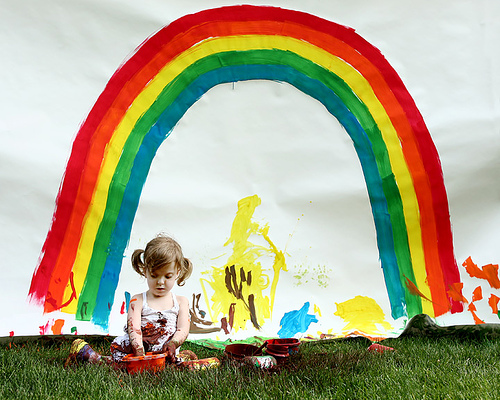

['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails painting outside in the grass .']

In [ ]:
z = Image(filename=images_path+lines[0])
display(z)
tokens[lines[0]]

In [ ]:
# Creating train, test and validation dataset files with header as 'image_id' and 'captions'
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

18

In [ ]:
x_train[:10]

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg',
 '488416045_1c6d903fe0.jpg',
 '2644326817_8f45080b87.jpg',
 '218342358_1755a9cce1.jpg',
 '2501968935_02f2cd8079.jpg',
 '2699342860_5288e203ea.jpg',
 '2638369467_8fc251595b.jpg',
 '2926786902_815a99a154.jpg']

In [ ]:
len(x_train)

6001

In [1]:
for img in x_train:
    if img =='':
        print('empty')
# There is one empty file

empty


### Pre-processing the data.

In [ ]:
inp_train_in=[]
target_train_in=[]
target_train_out=[]
target=[]

for img in x_train:
    
    if img=='':
        continue
    
    for capt in tokens[img]:
        decoder_in='<start> '+capt
        decoder_out=capt+' <end>'
        caption = "<start> "+ capt + " <end>"
        
        inp_train_in.append(img)
        target.append(caption)
        target_train_in.append(decoder_in)
        target_train_out.append(decoder_out)
        

In [ ]:
for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

### Modelling

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from tqdm import tqdm
import pandas as pd


Using TensorFlow backend.


Using Resnet50 with pre-trained weights as encoder model

In [ ]:
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
#model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
model.output.shape

TensorShape([Dimension(None), Dimension(2048)])

In [ ]:
def preprocess_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
a=preprocess_img(images_path+x_train[0])

In [ ]:
a.shape

(1, 224, 224, 3)

In [ ]:
train_image_data = {}
ctr=0
for ix in tqdm(x_train):
    if ix == "":
        continue
    if ctr >= 1000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + ix
    img = preprocess_img(path)
    pred = model.predict(img).reshape(2048)
    train_image_data[ix] = pred

  0%|          | 0/6001 [00:00<?, ?it/s]

 17%|█▋        | 1000/6001 [02:30<11:25,  7.30it/s]

1000


In [ ]:
train_image_data['2513260012_03d33305cf.jpg']

array([0.28047347, 0.406874  , 0.08379993, ..., 0.910792  , 0.04341809,
       0.09577919], dtype=float32)

In [ ]:
len(inp_train_in)*1/6

5000.0

In [ ]:
all_image_features=[]
for i in range(5000):
    all_image_features.append(train_image_data[inp_train_in[i]])
    

In [ ]:
img_feature_length=all_image_features[0].shape[0]

In [ ]:
image_features_1000=pd.DataFrame.from_dict(train_data,orient='index').reset_index().rename(columns={'index':'image_id'})

In [ ]:
image_features_1000.head()

,image_id,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,2632111399_b3c1630f8e.jpg,0.008402,1.121133,0.470087,0.471879,0.352778,0.090474,0.028695,0.030071,0.043330,...,0.463830,0.190700,0.073018,0.294733,0.553252,0.377915,0.127949,0.833190,1.124223,0.298710
1,2436398074_8737f40869.jpg,0.346445,0.195170,0.684508,0.000000,0.387455,0.471148,0.646087,0.000000,0.000000,...,0.004377,0.627457,0.815528,0.009067,0.347005,0.465264,0.038892,0.007488,0.083701,0.371678
2,2451988767_244bff98d1.jpg,0.042823,0.156018,0.003232,0.573679,0.664779,0.000000,0.000000,0.306686,0.141928,...,2.234214,0.012147,0.076939,3.395483,0.712132,0.674804,0.031256,1.159434,0.941327,0.000000
3,3201594926_cd2009eb13.jpg,0.164324,1.159387,0.053270,0.840297,0.222311,0.463923,0.933610,0.311275,1.440227,...,0.141469,0.014295,1.234569,1.908480,0.959512,0.043827,2.180104,0.754252,1.664453,0.890459
4,534200447_b0f3ff02be.jpg,0.908857,0.099877,0.300976,0.377944,0.609800,0.135912,0.011996,0.730782,1.832239,...,0.103699,0.029191,0.062844,1.096744,0.207809,0.112430,0.017011,0.229379,0.408692,0.161055


In [ ]:
pd_dataset = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

(30000, 2)


In [ ]:
pd_dataset.head()

,image_id,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...


In [ ]:
merged_data_1000=pd.merge(image_features_1000,pd_dataset,on='image_id')

In [ ]:
merged_data_1000.head()

,image_id,0,1,2,3,4,5,6,7,8,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,captions
0,2632111399_b3c1630f8e.jpg,0.008402,1.121133,0.470087,0.471879,0.352778,0.090474,0.028695,0.030071,0.04333,...,0.1907,0.073018,0.294733,0.553252,0.377915,0.127949,0.83319,1.124223,0.29871,"<start> A boy catcher in a helmet , stretching..."
1,2632111399_b3c1630f8e.jpg,0.008402,1.121133,0.470087,0.471879,0.352778,0.090474,0.028695,0.030071,0.04333,...,0.1907,0.073018,0.294733,0.553252,0.377915,0.127949,0.83319,1.124223,0.29871,<start> A catcher in a red and white uniform p...
2,2632111399_b3c1630f8e.jpg,0.008402,1.121133,0.470087,0.471879,0.352778,0.090474,0.028695,0.030071,0.04333,...,0.1907,0.073018,0.294733,0.553252,0.377915,0.127949,0.83319,1.124223,0.29871,<start> A catcher with a red shirt is standing...
3,2632111399_b3c1630f8e.jpg,0.008402,1.121133,0.470087,0.471879,0.352778,0.090474,0.028695,0.030071,0.04333,...,0.1907,0.073018,0.294733,0.553252,0.377915,0.127949,0.83319,1.124223,0.29871,<start> A child catcher reaching out his mitt ...
4,2632111399_b3c1630f8e.jpg,0.008402,1.121133,0.470087,0.471879,0.352778,0.090474,0.028695,0.030071,0.04333,...,0.1907,0.073018,0.294733,0.553252,0.377915,0.127949,0.83319,1.124223,0.29871,<start> The boy is bending down ready to catch...


In [ ]:
merged_data_1000.shape

(5000, 2050)

In [ ]:
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print(len(sentences))

30000


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [ ]:
sen_tokenizer=Tokenizer(num_words=5000,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
sen_tokenizer.fit_on_texts(target[:5000])


In [ ]:
vocab_size=len(sen_tokenizer.word_index)+1

In [ ]:
tar_index_word={}
tar_word_index={}
for key,value in sen_tokenizer.word_index.items():
  tar_index_word[value]=key 
  tar_word_index[key]=value

In [ ]:
text_seq_in=sen_tokenizer.texts_to_sequences(target_train_in)
text_seq_in=pad_sequences(text_seq_in[:5000],padding='post')

In [ ]:
text_seq_out=sen_tokenizer.texts_to_sequences(target_train_out)
text_seq_out=pad_sequences(text_seq_out[:5000],padding='post')

In [ ]:
text_seq_in.shape

In [ ]:
text_seq_in[0].shape

In [ ]:
text_seq_in[0:3]

In [ ]:
#Encoder input shape will be (Batch_size,inp_seq_length) --
input_encoder=Input(shape=(img_feature_length,))

encoder_state_h=Dense(256)(input_encoder)
encoder_state_c=Dense(256)(input_encoder)
encoder_states=[encoder_state_h,encoder_state_c]

In [ ]:
input_decoder = Input(shape=(None,))
# input_decoder shape is (None,None)

decoder_embedding_layer=Embedding(input_dim=vocab_size,output_dim=128)
decoder_embedding_output=decoder_embedding_layer(input_decoder)
# decoder_embedding_layer - (None,None,128) 

decoder_lstm=LSTM(256,return_sequences=True,return_state=True)
decoder_output,_,_=decoder_lstm(decoder_embedding_output,initial_state=encoder_states)

In [ ]:
decoder_dense=TimeDistributed( Dense(vocab_size,activation='softmax'))
dense_output= decoder_dense(decoder_output)

In [ ]:
model=Model([input_encoder,input_decoder],dense_output)

model.summary()

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
model.fit([all_image_features,text_seq_in],text_seq_out,epochs=20)

In [ ]:
encoder_model=Model(input_encoder,encoder_states)

In [ ]:
encoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          524544      input_5[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          524544      input_5[0][0]                    
Total params: 1,049,088
Trainable params: 1,049,088
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
decoder_state_h=Input(shape=(256))
decoder_state_c=Input(shape=(256))
decoder_state_inputs=[decoder_state_h,decoder_state_c]
decoder_embedding_output=decoder_embedding_layer(input_decoder)

In [ ]:
decoder_outputs,state_h,state_c=decoder_lstm(decoder_embedding_output,initial_state=decoder_state_inputs)
decoder_states=[state_h,state_c]
# Send the decoder outputs to the dense layer to get the predicted word
decoder_outputs=decoder_dense(decoder_outputs)

In [ ]:

# decoder model takes two inputs 1. Decoder input 2. Decoder initial states
# returns two outputs 1. Decoder outputs 2. decoder states(hidden_state and cell state)
decoder_model=Model([input_decoder]+decoder_state_inputs,[decoder_outputs]+decoder_states)

In [ ]:
decoder_model.summary(line_length=150)

Model: "model_4"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_6 (InputLayer)                             [(None, None)]                   0                                                                   
______________________________________________________________________________________________________________________________________________________
embedding_2 (Embedding)                          (None, None, 128)                944256            input_6[0][0]                                     
______________________________________________________________________________________________________________________________________________________
input_9 (InputLayer)                             [(None, 256)]               

In [ ]:
def inference(seq):
  '''
    Function that takes Italian sequence and returns English sequence
  '''
  # Input the sequence to encoder_model and get the final timestep encoder_states(Hidden and cell state)
  
  seq=seq.reshape(-1,2048)
  encoder_state_value=encoder_model.predict(seq)
  #encoder_state_value=encoder_state_value[1:]
  # encoder_state_value[0] -- hidden_state -- shape (None,256)
  # encoder_state_value[1] -- cell_state -- shape (None,256)

  # Target word
  target_word=np.zeros((1,1))
  # <start>:1 , <end>:2 -- 
  target_word[0,0]=1
  
  stop_condition=False
  sent=''
  k=0
  while not stop_condition:

      # We are giving a target_word which represents <start> and encoder_states to the decoder_model
      output,state_h,state_c=decoder_model.predict([target_word]+encoder_state_value)
      # As the target word length is 1. We will only have one time step
      encoder_state_value=[state_h,state_c]
      # Output shape (1,eng_vocab_size). Find the word which the decoder predicted with max_probability
      output=np.argmax(output,-1)
      print(output)
      # The output is a integer sequence, to get back the word. We use our lookup table reverse_dict
      sent=sent+' '+tar_index_word[int(output)]
      k+=1
      # If the max_length of the sequence is reached or the model predicted 2 (<end>) stop your model
      if k>20 or output==4:
        stop_condition=True
      target_word=output.reshape(1,1)
  
  return sent





In [ ]:
import random

In [ ]:
index=random.randint(1,200)

In [ ]:
pred=inference(all_image_features[index])

[[2]]
[[202]]
[[114]]
[[5]]
[[2]]
[[23]]
[[32]]
[[8]]
[[36]]
[[22]]
[[184]]
[[2]]
[[41]]
[[4]]


In [ ]:
pred

' a baseball player in a red shirt is running to catch a ball <end>'

### Actual Prediction

In [ ]:
lines=captions[index].split('#')

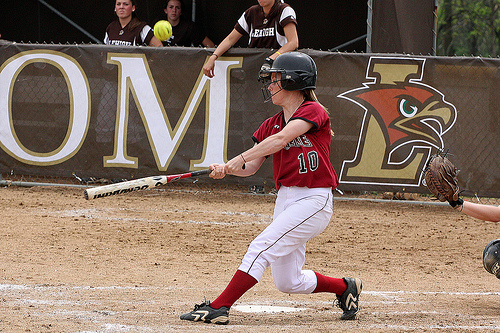

['a baseball player in a red shirt and white pants is swinging the bat towards a yellow ball whilst three people look on .',
 'A baseball player recoils from an action involving a bat while opposing team members look on .',
 'A girl in a red and white uniform is swinging a bat .',
 'A girl swings a bat during a softball game .',
 'A woman swings at a softball on a playing field while other players look on .']

In [ ]:
z = Image(filename=images_path+lines[0])
display(z)
tokens[lines[0]]